In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### 3.4 Actividad final: Simulación relacionada con su pregunta de investigación

Para completar este notebook, realice una simulación estadística que se relacione con su potencial pregunta de investigación. Esta simulación debe:

1. Generar datos que modelen el fenómeno que quieren estudiar
2. Aplicar una prueba estadística apropiada
3. Interpretar los resultados en el contexto de su proyecto

In [14]:
# Cargamos los datos (usamos una muestra para este notebook)
# En caso de que no funcione la carga directa, ajustar la ruta al archivo
import polars as pl

try:
    columnas_fecha = ["FECHA_NACIMIENTO", "FECHA_INGRESO", "FECHAALTA"]
    df = pl.scan_csv("data/GRD_2023_muestra_cancer_UCV.csv", null_values=["DESCONOCIDO"])
    df = df.with_columns([
        pl.coalesce([
            pl.col(col).str.strptime(pl.Date, "%d-%m-%Y", strict=False),
            pl.col(col).str.strptime(pl.Date, "%Y-%m-%d", strict=False)
        ]).alias(col)  # 
        for col in columnas_fecha
    ])
    # Finalmente, materializamos el DataFrame en memoria (si usas lazy):
    df = df.collect()
    grd_data = df.to_pandas()
    print("CSV CARGADO")

except:
    # Este es un dataset simulado para el notebook en caso de no tener acceso al archivo real
    # Solo para fines didácticos
    n_samples = 1000
    grd_data = pd.DataFrame({
        'COD_HOSPITAL': np.random.randint(100000, 200000, n_samples),
        'CIP_ENCRIPTADO': np.random.randint(1000000, 9000000, n_samples),
        'SEXO': np.random.choice(['M', 'F'], n_samples),
        'FECHA_NACIMIENTO': [pd.Timestamp('1940-01-01') + 
                            pd.Timedelta(days=np.random.randint(0, 365*70)) for _ in range(n_samples)],
        'SERVICIO_SALUD': np.random.choice(['METROPOLITANO CENTRAL', 'METROPOLITANO NORTE', 
                                          'METROPOLITANO SUR', 'METROPOLITANO ORIENTE'], n_samples),
        'TIPO_INGRESO': np.random.choice(['URGENCIA', 'ELECTIVO'], n_samples),
        'FECHA_INGRESO': [pd.Timestamp('2023-01-01') + 
                          pd.Timedelta(days=np.random.randint(0, 364)) for _ in range(n_samples)],
        'FECHAALTA': [pd.Timestamp('2023-01-01') + 
                     pd.Timedelta(days=np.random.randint(1, 365)) for _ in range(n_samples)],
        'TIPOALTA': np.random.choice(['DOMICILIO', 'TRASLADO', 'FALLECIMIENTO'], 
                                   n_samples, p=[0.8, 0.15, 0.05]),
        'DIAGNOSTICO1': np.random.choice(['C61', 'C67', 'C64', 'C50', 'I10'], 
                                       n_samples, p=[0.3, 0.2, 0.2, 0.2, 0.1]),
        'IR_29301_COD_GRD': np.random.choice([101101, 101102, 101103, 114101, 114102], n_samples),
        'IR_29301_PESO': np.random.uniform(0.5, 3.0, n_samples).astype(str),
        'IR_29301_SEVERIDAD': np.random.choice([0, 1, 2, 3], n_samples),
        'IR_29301_MORTALIDAD': np.random.choice([0, 1, 2, 3], n_samples),
    })
    print("CSV NOT FOUND")

# Mostramos información básica del dataframe
print("Información del dataset GRD:")
print(f"Tamaño: {grd_data.shape[0]} filas, {grd_data.shape[1]} columnas")
print("\nColumnas disponibles:")
for col in grd_data.columns:
    print(f"- {col}")
    
print("\nPrimeras 5 filas:")
grd_data.head()

CSV NOT FOUND
Información del dataset GRD:
Tamaño: 1000 filas, 14 columnas

Columnas disponibles:
- COD_HOSPITAL
- CIP_ENCRIPTADO
- SEXO
- FECHA_NACIMIENTO
- SERVICIO_SALUD
- TIPO_INGRESO
- FECHA_INGRESO
- FECHAALTA
- TIPOALTA
- DIAGNOSTICO1
- IR_29301_COD_GRD
- IR_29301_PESO
- IR_29301_SEVERIDAD
- IR_29301_MORTALIDAD

Primeras 5 filas:


,COD_HOSPITAL,CIP_ENCRIPTADO,SEXO,FECHA_NACIMIENTO,SERVICIO_SALUD,TIPO_INGRESO,FECHA_INGRESO,FECHAALTA,TIPOALTA,DIAGNOSTICO1,IR_29301_COD_GRD,IR_29301_PESO,IR_29301_SEVERIDAD,IR_29301_MORTALIDAD
0,144509,1999963,F,1973-10-09,METROPOLITANO NORTE,URGENCIA,2023-04-24,2023-11-22,DOMICILIO,I10,114102,2.7468884976321295,0,0
1,119968,3139358,M,1969-05-27,METROPOLITANO ORIENTE,ELECTIVO,2023-06-30,2023-04-09,DOMICILIO,I10,101101,1.721397476908136,2,0
2,147742,6243168,F,1971-12-23,METROPOLITANO CENTRAL,URGENCIA,2023-11-03,2023-10-11,DOMICILIO,C61,114102,2.2744990405802286,2,1
3,114556,3357809,M,2004-04-21,METROPOLITANO ORIENTE,ELECTIVO,2023-12-19,2023-11-04,TRASLADO,C61,101103,2.9165194163391073,1,0
4,165000,4736562,M,2004-04-18,METROPOLITANO ORIENTE,URGENCIA,2023-07-16,2023-12-01,DOMICILIO,C50,114101,0.728037039923123,1,3


In [15]:
grd_data[["IR_29301_MORTALIDAD", "SEXO", "FECHA_NACIMIENTO", "FECHA_INGRESO", "FECHAALTA"]].head()
grd_data["SERVICIO_SALUD"].value_counts()

SERVICIO_SALUD
METROPOLITANO NORTE      257
METROPOLITANO SUR        253
METROPOLITANO ORIENTE    250
METROPOLITANO CENTRAL    240
Name: count, dtype: int64

## Simulacion

In [16]:

print("SIMULACIÓN DE DATOS PARA ANÁLISIS DE MORTALIDAD POR SERVICIO")

#Primero hacemos una simulacion levantando los siuientes datos:
#-Mortalidad x
#-Dias estancia x
#-Enfermedad x
#-Servicio_Salud 
#-Paciente

# 1. Simulamos datos
#np.random.seed(123)
n = 2000  # número de pacientes

# Severidad como variable categórica (0, 1, 2, 3)
mortalidad = np.random.choice([0, 1, 2, 3], size=n, p=[0.2, 0.3, 0.3, 0.2])

# Días de estancia que aumentan con la severidad (simulando una relación)
# Usamos diferentes parámetros de distribución gamma para cada nivel de severidad
dias_estancia = np.zeros(n)
for i in range(n):
    if mortalidad[i] == 0:
        dias_estancia[i] = np.random.gamma(shape=1.5, scale=2, size=1)
    elif mortalidad[i] == 1:
        dias_estancia[i] = np.random.gamma(shape=2, scale=2.5, size=1)
    elif mortalidad[i] == 2:
        dias_estancia[i] = np.random.gamma(shape=3, scale=3, size=1)
    else:  # severidad 3
        dias_estancia[i] = np.random.gamma(shape=4, scale=4, size=1)
#Enfermedad
enfermedad= np.empty(n, dtype=object)
for i in range(n):
    if mortalidad[i] == 0:
        enfermedad[i] = np.random.choice(["Resfriado","sinusitis","sarampion","varicela"],p=[0.4,0.3,0.2,0.1])
    elif mortalidad[i] == 1:
        enfermedad[i] = np.random.choice(["Hypotiroidismo","Hypertiroidismo","Gripe","viruela(Vacunados)"],p=[0.4,0.3,0.2,0.1])
    elif mortalidad[i] == 2:
        enfermedad[i] = np.random.choice(["Diarrea","Diabetes","Colealitis","Pneumonia"],p=[0.4,0.3,0.2,0.1])
    else:  # severidad 3
        enfermedad[i] = np.random.choice(["Paro Cardiaco","Derrame Cerebral","Tuberculosis","Cirrosis hepática"],p=[0.4,0.3,0.2,0.1])

#Servicios salud
sevs=["METROPOLITANA","VALDIVIA","VIÑA DEL MAR","PUERTO MONTT","PUERTO VARAS"]
servicio_salud= np.empty(n, dtype=object)
for i in range(n):
    if np.random.randint(0,1)==0:
        servicio_salud[i]= np.random.choice(sevs,p=[0.4,0.2,0.2,0.1,0.1])
    else:
         servicio_salud[i]= np.random.choice(sevs,p=[0.4,0.2,0.2,0.1,0.1])

paciente= np.empty(n, dtype=object)
for i in range(n):
    paciente[i] = np.random.randint(1000000, 3000000)   

# Creamos un DataFrame
sim_data = pd.DataFrame({
    'Mortalidad': mortalidad,
    'Dias_estancia': dias_estancia,
    'Enfermedad': enfermedad,
    'Servicio_Salud': servicio_salud,
    'ID_Pacienete': paciente,

    'Mortalidad_cat': pd.Categorical(mortalidad, categories=[0, 1, 2, 3], 
                                    ordered=True).map({0: 'Sin gravedad', 1: 'Menor', 
                                                     2: 'Moderada', 3: 'Mayor'})
})

sim_data

SIMULACIÓN DE DATOS PARA ANÁLISIS DE MORTALIDAD POR SERVICIO


C:\Users\Larsi\AppData\Local\Temp\ipykernel_40148\3754834788.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dias_estancia[i] = np.random.gamma(shape=2, scale=2.5, size=1)
C:\Users\Larsi\AppData\Local\Temp\ipykernel_40148\3754834788.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dias_estancia[i] = np.random.gamma(shape=3, scale=3, size=1)
C:\Users\Larsi\AppData\Local\Temp\ipykernel_40148\3754834788.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dia

,Mortalidad,Dias_estancia,Enfermedad,Servicio_Salud,ID_Pacienete,Mortalidad_cat
0,1,1.147848,Hypotiroidismo,METROPOLITANA,2878661,Menor
1,2,2.241926,Diarrea,PUERTO VARAS,2424001,Moderada
2,1,7.428772,Gripe,METROPOLITANA,2644438,Menor
3,3,11.608193,Paro Cardiaco,METROPOLITANA,1516873,Mayor
4,0,0.264777,sinusitis,METROPOLITANA,2545657,Sin gravedad
...,...,...,...,...,...,...
1995,1,0.937352,Hypotiroidismo,METROPOLITANA,1274271,Menor
1996,3,20.698037,Cirrosis hepática,METROPOLITANA,2120135,Mayor
1997,2,9.368080,Diarrea,VALDIVIA,2534429,Moderada
1998,1,2.864516,Gripe,METROPOLITANA,1155431,Menor


In [17]:
sim_data["Servicio_Salud"].value_counts()

Servicio_Salud
METROPOLITANA    765
VIÑA DEL MAR     412
VALDIVIA         390
PUERTO VARAS     233
PUERTO MONTT     200
Name: count, dtype: int64

C:\Users\Larsi\AppData\Local\Temp\ipykernel_40148\274439425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Mortalidad_cat', y='Dias_estancia', data=sim_data, palette='YlOrRd')


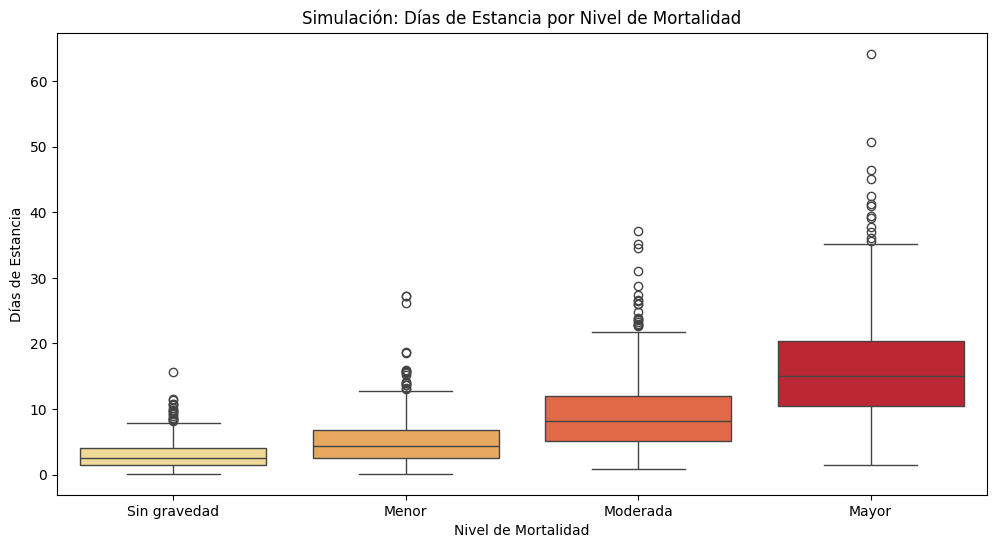

Resultados del ANOVA:
Estadístico F: 510.9283
p-valor: 0.0000
Conclusión: Hay diferencias significativas entre los grupos

Estadísticas descriptivas por nivel de severidad:


C:\Users\Larsi\AppData\Local\Temp\ipykernel_40148\274439425.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(sim_data.groupby('Mortalidad_cat')['Dias_estancia'].describe())


,count,mean,std,min,25%,50%,75%,max
Mortalidad_cat,,,,,,,,
Sin gravedad,407.0,3.088162,2.359586,0.170991,1.398305,2.583336,4.118975,15.650073
Menor,597.0,5.144845,3.659201,0.143217,2.600107,4.319997,6.751327,27.223323
Moderada,601.0,9.197036,5.562602,0.867242,5.172417,8.178668,11.990626,37.127565
Mayor,395.0,16.519899,8.532157,1.517581,10.490260,15.086241,20.430838,64.185065


In [18]:
# 2. Visualizamos la relación
plt.figure(figsize=(12, 6))
sns.boxplot(x='Mortalidad_cat', y='Dias_estancia', data=sim_data, palette='YlOrRd')
plt.title('Simulación: Días de Estancia por Nivel de Mortalidad')
plt.xlabel('Nivel de Mortalidad')
plt.ylabel('Días de Estancia')
plt.show()

# 3. Análisis estadístico: ANOVA para comparar medias entre grupos
from scipy.stats import f_oneway

# Separamos los grupos
grupo0 = sim_data[sim_data['Mortalidad'] == 0]['Dias_estancia']
grupo1 = sim_data[sim_data['Mortalidad'] == 1]['Dias_estancia']
grupo2 = sim_data[sim_data['Mortalidad'] == 2]['Dias_estancia']
grupo3 = sim_data[sim_data['Mortalidad'] == 3]['Dias_estancia']

# Realizamos ANOVA
f_stat, p_valor = f_oneway(grupo0, grupo1, grupo2, grupo3)

print(f"Resultados del ANOVA:")
print(f"Estadístico F: {f_stat:.4f}")
print(f"p-valor: {p_valor:.4f}")
print(f"Conclusión: {'Hay diferencias significativas entre los grupos' if p_valor < 0.05 else 'No hay diferencias significativas entre los grupos'}")

# 4. Resumen descriptivo por grupo
print("\nEstadísticas descriptivas por nivel de severidad:")
display(sim_data.groupby('Mortalidad_cat')['Dias_estancia'].describe())

# Su turno: Modifique este ejemplo o cree una nueva simulación
# relacionada con su pregunta de investigación